In this notebook, we run a logistic regression on the initial data set to see how well the features provided can predict delinquency, since that is the ultimate goal of a credit score. Later, as the data are transformed and logistic regression is applied to determine a credit score card, we will be able to compare the predictive power of the data before and after the transformation.

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer

In [10]:
df_no_null = pd.read_csv('../../data/train_no_nulls.csv')

In [11]:
df_no_null.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


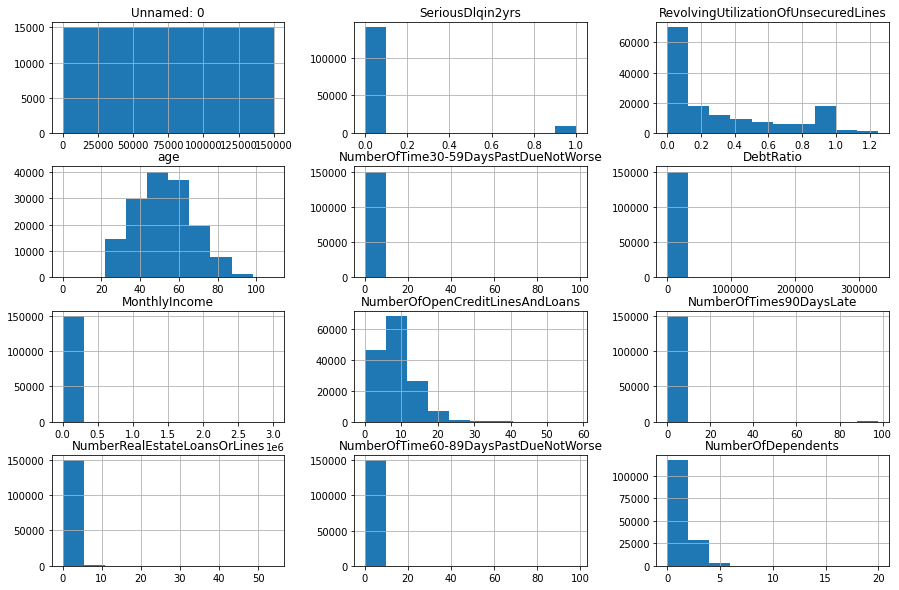

In [12]:
df_no_null.hist(figsize=(15,10));

In [28]:
df_no_null.drop('Unnamed: 0', axis=1, inplace=True)

In this data, missing values have already been replaced by imputing with the median. There are also some very large outliers, some of which make little sense, such as debt ratios over 300,000. These extreme outliers will be removed.

### Handling Outliers ###

<AxesSubplot:>

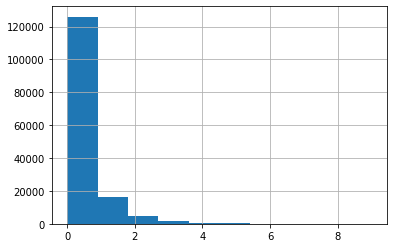

In [ ]:
df_no_null[df_no_null['NumberOfTime30-59DaysPastDueNotWorse']<10]['NumberOfTime30-59DaysPastDueNotWorse'].hist();

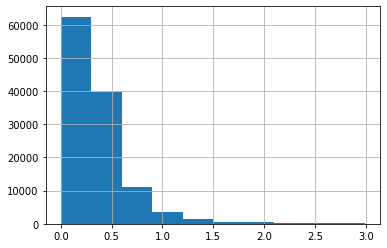

In [46]:
df_no_null[df_no_null['DebtRatio']<3]['DebtRatio'].hist();

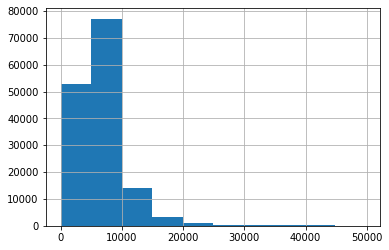

In [55]:
df_no_null[df_no_null['MonthlyIncome']<50_000]['MonthlyIncome'].hist();

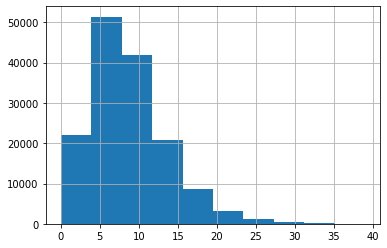

In [61]:
df_no_null[df_no_null['NumberOfOpenCreditLinesAndLoans']<40]['NumberOfOpenCreditLinesAndLoans'].hist();

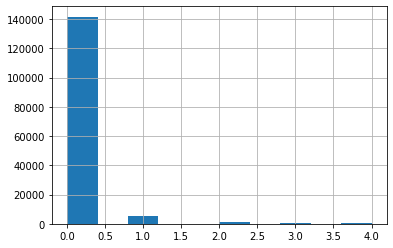

In [63]:
df_no_null[df_no_null['NumberOfTimes90DaysLate']<5]['NumberOfTimes90DaysLate'].hist();

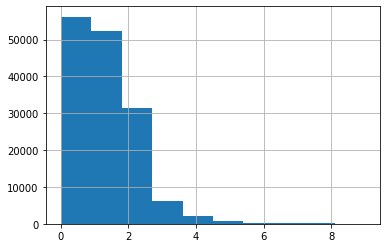

In [67]:
df_no_null[df_no_null['NumberRealEstateLoansOrLines']<10]['NumberRealEstateLoansOrLines'].hist();

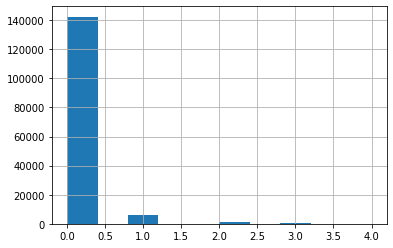

In [70]:
df_no_null[df_no_null['NumberOfTime60-89DaysPastDueNotWorse']<5]['NumberOfTime60-89DaysPastDueNotWorse'].hist();

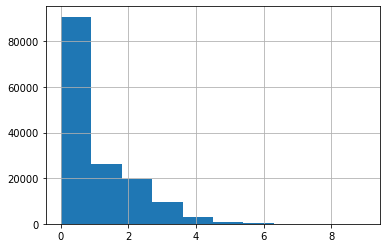

In [73]:
df_no_null[df_no_null['NumberOfDependents']<10]['NumberOfDependents'].hist();

In [74]:
outlier_rows = list(df_no_null.index[(df_no_null['NumberOfTime30-59DaysPastDueNotWorse']>10) |
                                    (df_no_null['DebtRatio']>3) |
                                    (df_no_null['MonthlyIncome']>50_000) |
                                    (df_no_null['NumberOfOpenCreditLinesAndLoans']>40) |
                                    (df_no_null['NumberOfTimes90DaysLate']>5) |
                                    (df_no_null['NumberRealEstateLoansOrLines']>10) |
                                    (df_no_null['NumberOfTime60-89DaysPastDueNotWorse']>5) |
                                    (df_no_null['NumberOfDependents']>10)])

In [76]:
len(outlier_rows)

31110

In [78]:
df_no_null_outlier = df_no_null.drop(index=outlier_rows)

### Class Imbalance ###

In [79]:
df_no_null_outlier['SeriousDlqin2yrs'].value_counts()

0    110818
1      8072
Name: SeriousDlqin2yrs, dtype: int64

In [80]:
df_no_null_outlier['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.932105
1    0.067895
Name: SeriousDlqin2yrs, dtype: float64

Class imbalance is extreme, with most people not being delinquent. Since we have over 8000 who are delinquent, we will undersample the non-delinquent to achieve balanced classes. This still gives us over 16000 data points for our regression.

In [81]:
df_not_delinquent = df_no_null_outlier[df_no_null_outlier['SeriousDlqin2yrs']==0].sample(n=8072, random_state=42)

In [82]:
df_delinquent = df_no_null_outlier[df_no_null_outlier['SeriousDlqin2yrs']==1]

In [83]:
df_not_delinquent.shape

(8072, 11)

In [84]:
df_delinquent.shape

(8072, 11)

In [87]:
df_combined = pd.concat([df_not_delinquent, df_delinquent])

In [102]:
X = df_combined.drop('SeriousDlqin2yrs', axis=1)
y = df_combined['SeriousDlqin2yrs']

In [103]:
scaler = StandardScaler()

In [104]:
X_scaled = scaler.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

In [106]:
y_train.mean()

0.4981004294681203

In [107]:
y_test.mean()

0.5056987115956393

The target is nearly evenly split between the train and test data.

### Predicting delinquency with logistic regression. ###

In [110]:
logreg = LogisticRegression()

In [116]:
logreg.fit(X_train, y_train);

In [117]:
y_test_predicted = logreg.predict(X_test)

In [128]:
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1995
           1       0.78      0.73      0.75      2041

    accuracy                           0.76      4036
   macro avg       0.76      0.76      0.76      4036
weighted avg       0.76      0.76      0.76      4036



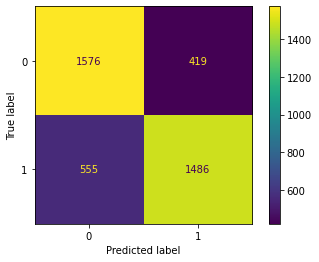

In [124]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predicted);

A baseline logistic regression with this data is about 76% acccurate in predicting delinquency.

### Checking Accuracy with Kaggle Test Set ###

In [159]:
kaggle_test = pd.read_csv('../../data/cs-test.csv')

In [160]:
kaggle_test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [161]:
kaggle_test = kaggle_test.drop(columns=['Unnamed: 0', 'SeriousDlqin2yrs'])

In [162]:
# Function for imputing a specified strategy
def impute(df, column, strategy):
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp.fit(df[column].values.reshape(-1,1))
    return imp.transform(df[column].values.reshape(-1,1))

In [163]:
# Impute Monthly Income
kaggle_test['MonthlyIncome'] = impute(df=kaggle_test, column='MonthlyIncome', strategy='mean')

In [164]:
# Impute Number of Dependents
kaggle_test['NumberOfDependents'] = impute(df=kaggle_test, column='NumberOfDependents', strategy='mean')

In [165]:
scaler_kaggle = StandardScaler()

In [166]:
kaggle_test_scaled = scaler_kaggle.fit_transform(kaggle_test)

In [167]:
y_test_predicted = logreg.predict_proba(kaggle_test_scaled)

In [170]:
y_test_predicted

array([[0.5136292 , 0.4863708 ],
       [0.37350861, 0.62649139],
       [0.46145385, 0.53854615],
       ...,
       [0.60918911, 0.39081089],
       [0.36001701, 0.63998299],
       [0.38214   , 0.61786   ]])

In [171]:
predictions = pd.DataFrame(y_test_predicted)

In [173]:
predictions.head()

,0,1
0,0.513629,0.486371
1,0.373509,0.626491
2,0.461454,0.538546
3,0.397762,0.602238
4,0.435560,0.564440


For submission to Kaggle, we need only the probability of default.

In [178]:
predictions = predictions.drop(columns=0)

In [180]:
predictions.index += 1

In [183]:
predictions['Id'] = predictions.index

In [189]:
predictions = predictions.rename(columns={1: 'Probability'})

In [190]:
predictions.head()

,Probability,Id
1,0.486371,1
2,0.626491,2
3,0.538546,3
4,0.602238,4
5,0.564440,5


In [192]:
predictions.to_csv('../../data/kaggle_sub_raw.csv', columns=['Id', 'Probability'], index=False)

The above submission performed with 73% accuracy on Kaggle.